### altimetry data processing 

In [97]:
import numpy as np
from glob import glob
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.functions import sample_from_raster


In [112]:
path_geoid_cor = 'data/hulun-lake/swot-pixc/raster_geoid_cor_smoothed.nc'
path_lake_vec = 'data/hulun-lake/hydrolake_hulun.gpkg'
paths_atl13 = sorted(glob('data/hulun-lake/icesat2/ATL13/*.h5'))
paths_atl13[0]  # check the selected ATL13 file


'data/hulun-lake/icesat2/ATL13/106772971_ATL13_20240721011047_05132401_006_01_subsetted.h5'

In [113]:
## read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec)
# ## read geoid correction file
raster_geoid_cor = xr.open_dataset(path_geoid_cor) 
## read ATL13 data
atl13_xr = xr.open_dataset(paths_atl13[0], group='gt1r', engine='h5netcdf')
atl13_xr


<xarray.Dataset> Size: 174kB
Dimensions:                        (delta_time: 431, ds_sseg_quality: 4)
Coordinates:
  * delta_time                     (delta_time) datetime64[ns] 3kB 2024-07-21...
    segment_lat                    (delta_time) float64 3kB ...
    segment_lon                    (delta_time) float64 3kB ...
Dimensions without coordinates: ds_sseg_quality
Data variables: (12/72)
    atl13refid                     (delta_time) float64 3kB ...
    bottom_lat                     (delta_time) float64 3kB ...
    bottom_lon                     (delta_time) float64 3kB ...
    cloud_flag_asr_atl09           (delta_time) float32 2kB ...
    cloud_flag_atm_atl09           (delta_time) float32 2kB ...
    cycle_number                   (delta_time) int8 431B ...
    ...                             ...
    sseg_start_lon                 (delta_time) float64 3kB ...
    stdev_water_surf               (delta_time) float32 2kB ...
    subsurface_attenuation         (delta_time) float32 2kB ...
    subsurface_backscat_ampltd     (delta_time) float32 2kB ...
    transect_id                    (delta_time) float32 2kB ...
    water_depth                    (delta_time) float32 2kB ...
Attributes:
    Description:         Contains per-beam data products.
    atlas_beam_type:     weak
    atlas_pce:           pce1
    atlas_spot_number:   2
    atmosphere_profile:  profile_1
    data_rate:           Data within this group are stored at the inland wate...
    groundtrack_id:      gt1r
    sc_orientation:      Backward

Text(0.5, 1.0, 'Geoid')

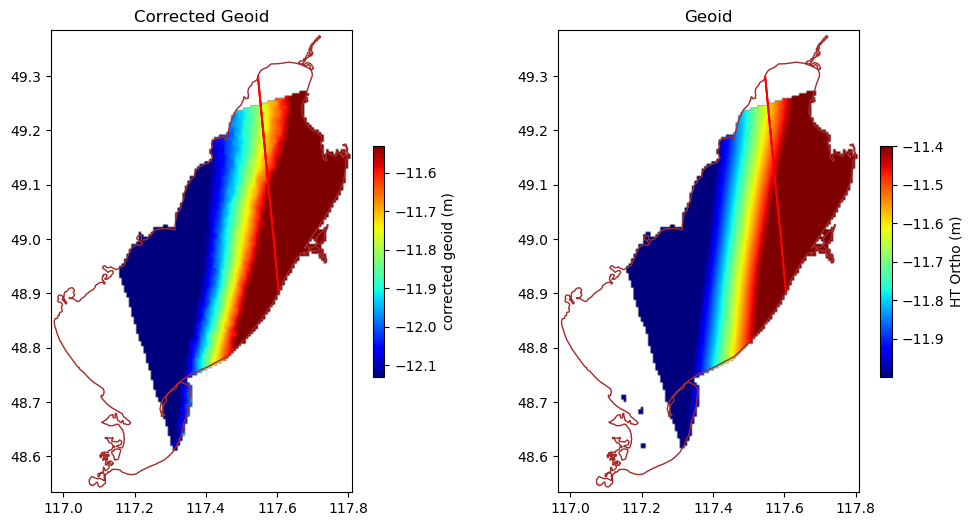

In [114]:
extent_raster = [raster_geoid_cor.x.min(), raster_geoid_cor.x.max(),
           raster_geoid_cor.y.min(), raster_geoid_cor.y.max()]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
geoid_mean = np.nanmean(raster_geoid_cor.geoid_cor_smoothed.values)
img_show1 = ax[0].imshow(raster_geoid_cor.geoid_cor_smoothed.values, cmap='jet', 
                        vmin = geoid_mean-0.3, vmax = geoid_mean+0.3, extent=extent_raster)
lake_gdf.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=1)
scat1 = ax[0].scatter(x=atl13_xr.segment_lon, y=atl13_xr.segment_lat, 
                      c='red', s=2, edgecolor='none')
plt.colorbar(img_show1, ax=ax[0], label='corrected geoid (m)', shrink=0.5)
ax[0].set_title('Corrected Geoid')
geoid_mean = np.nanmean(raster_geoid_cor.geoid.values)
img_show2 = ax[1].imshow(raster_geoid_cor.geoid.values, cmap='jet', 
                         vmin = geoid_mean-0.3, vmax = geoid_mean+0.3,
                         extent=extent_raster)
lake_gdf.plot(ax=ax[1], edgecolor='Brown', facecolor='none', linewidth=1)
scat2 = ax[1].scatter(x=atl13_xr.segment_lon, y=atl13_xr.segment_lat,                       
                      c='red', s=2, edgecolor='none')
plt.colorbar(img_show2, ax=ax[1], label='HT Ortho (m)', shrink=0.5)
ax[1].set_title('Geoid')



### apply the corrected geoid 

In [115]:
## Sample corrected geoid values at ATL13 points
atl13_geoid_cor = sample_from_raster(
        raster_value=raster_geoid_cor.geoid_cor_smoothed.values,
        raster_x = raster_geoid_cor.x.values,
        raster_y = raster_geoid_cor.y.values,
        points_x = atl13_xr.segment_lon.values,
        points_y = atl13_xr.segment_lat.values
        )

atl13_geoid_sam = sample_from_raster(
        raster_value=raster_geoid_cor.geoid.values,
        raster_x = raster_geoid_cor.x.values,
        raster_y = raster_geoid_cor.y.values,
        points_x = atl13_xr.segment_lon.values,
        points_y = atl13_xr.segment_lat.values
        )
atl13_height_geoid = atl13_xr.ht_water_surf.values - atl13_xr.segment_geoid.values  ## equal to atl13_xr.ht_ortho
atl13_height_geoid_cor = atl13_xr.ht_water_surf.values - atl13_geoid_cor


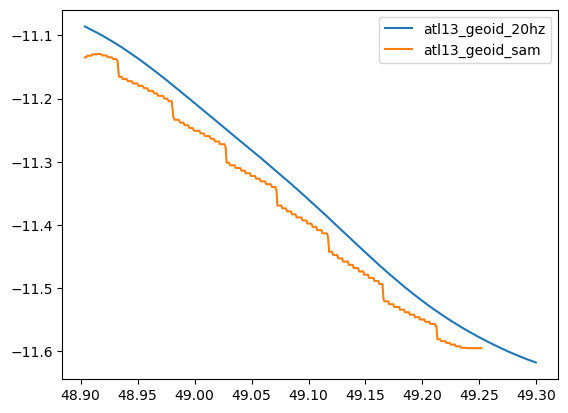

In [116]:
plt.plot(atl13_xr['segment_lat'], atl13_xr.segment_geoid.values, label='atl13_geoid_20hz')
plt.plot(atl13_xr['segment_lat'], atl13_geoid_sam, label='atl13_geoid_sam')
plt.legend()


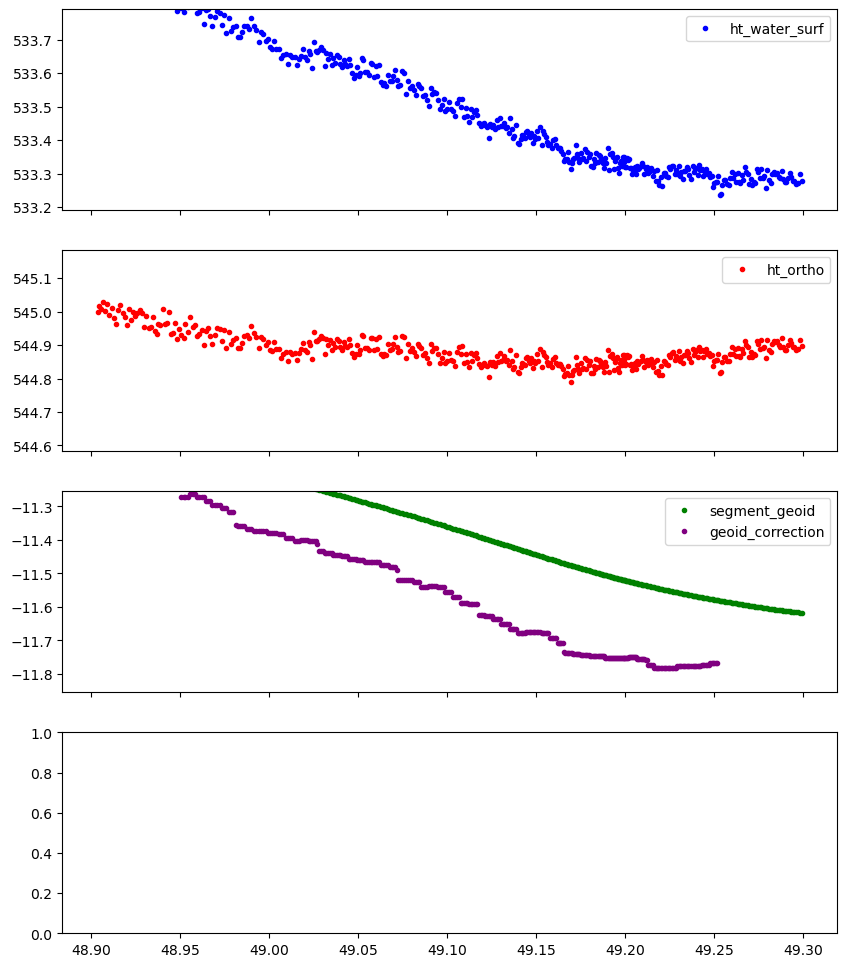

In [117]:
fig, ax = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
ht_mean = np.mean(atl13_xr.ht_water_surf.values)
ax[0].plot(atl13_xr['segment_lat'], atl13_xr.ht_water_surf.values, 
         marker='o', markersize=3, linestyle='None', 
         color='blue', label='ht_water_surf')
ax[0].set_ylim(ht_mean - 0.3, ht_mean + 0.3)
ax[0].legend()
ht_mean = np.mean(atl13_xr.ht_ortho.values)
ax[1].plot(atl13_xr['segment_lat'], atl13_xr.ht_ortho.values, 
         marker='o', markersize=3, linestyle='None', 
         color='red', label='ht_ortho')
ax[1].set_ylim(ht_mean - 0.3, ht_mean + 0.3)
ax[1].legend()
geoid_mean = np.mean(atl13_xr.segment_geoid.values)
ax[2].plot(atl13_xr['segment_lat'], atl13_xr.segment_geoid.values, 
         marker='o', markersize=3, linestyle='None', 
         color='green', label='segment_geoid')
ax[2].set_ylim(geoid_mean - 0.3, geoid_mean + 0.3)
ax[2].legend()
geoid_mean = np.nanmean(atl13_geoid_cor)
ax[2].plot(atl13_xr['segment_lat'], atl13_geoid_cor,
         marker='o', markersize=3, linestyle='None', 
         color='purple', label='geoid_correction')
ax[2].set_ylim(geoid_mean - 0.3, geoid_mean + 0.3)
ax[2].legend()


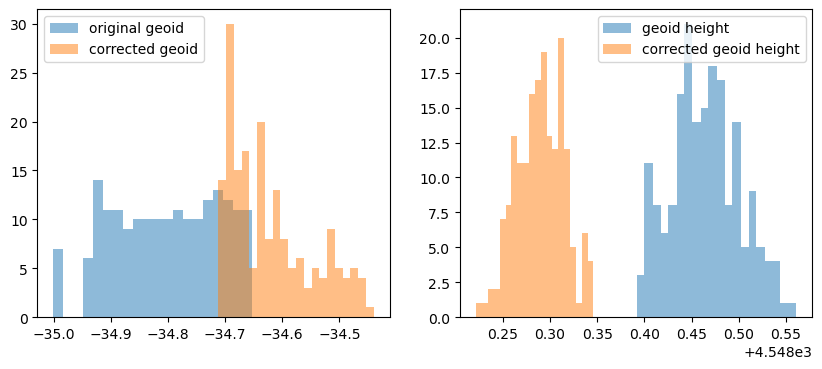

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(atl13_xr.segment_geoid.values.ravel(), bins=20, alpha=0.5, label='original geoid');
ax[0].hist(atl13_geoid_cor.ravel(), bins=20, alpha=0.5, label='corrected geoid');
ax[0].legend();
ax[1].hist(atl13_height_geoid, bins=20, alpha=0.5, label='geoid height');
ax[1].hist(atl13_height_geoid_cor, bins=20, alpha=0.5, label='corrected geoid height');
ax[1].legend();


In [91]:
atl13_height_ds = xr.Dataset({
  "geoid": (["delta_time"], atl13_xr.segment_geoid.values),
  "geoid_cor": (["delta_time"], atl13_geoid_cor),  
  "height_geoid": (["delta_time"], atl13_height_geoid),
  "height_geoid_cor": (["delta_time"], atl13_height_geoid_cor)
}, coords={
  "delta_time": atl13_xr["delta_time"],
  "segment_lon": atl13_xr["segment_lon"],
  "segment_lat": atl13_xr["segment_lat"]
})

# path_save = 'data/result/hulun_atl13_geoid_height.nc'
# atl13_height_ds.to_netcdf(path_save)
atl13_height_ds


<xarray.Dataset> Size: 9kB
Dimensions:           (delta_time: 188)
Coordinates:
  * delta_time        (delta_time) datetime64[ns] 2kB 2024-07-28T04:36:33.323...
    segment_lat       (delta_time) float64 2kB 31.73 31.74 31.74 ... 31.99 31.99
    segment_lon       (delta_time) float64 2kB 88.9 88.9 88.9 ... 88.87 88.87
Data variables:
    geoid             (delta_time) float32 752B -34.65 -34.65 ... -35.0 -35.0
    geoid_cor         (delta_time) float64 2kB -34.44 -34.46 -34.46 ... nan nan
    height_geoid      (delta_time) float32 752B 4.549e+03 ... 4.548e+03
    height_geoid_cor  (delta_time) float64 2kB 4.548e+03 4.548e+03 ... nan nan

In [92]:
print('std of geoid height:          ', np.nanstd(atl13_height_ds['height_geoid']))
print('std of geoid height corrected:', np.nanstd(atl13_height_ds['height_geoid_cor']))


std of geoid height:           0.03621222
std of geoid height corrected: 0.024925793737094748


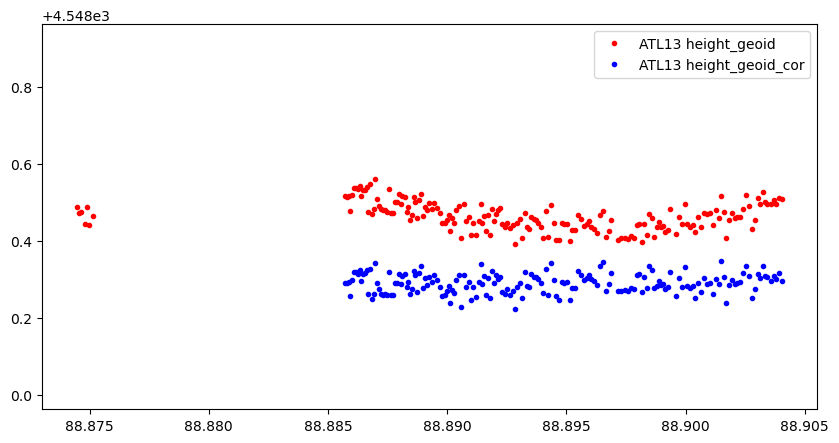

In [93]:
height_geoid_median = np.nanmedian(atl13_height_ds['height_geoid'])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(atl13_xr.segment_lon, atl13_height_ds['height_geoid'], 
                  marker='o', markersize=3, linestyle='None', 
                  color='red', label='ATL13 height_geoid')

ax.plot(atl13_xr.segment_lon, atl13_height_ds['height_geoid_cor'], 
                  marker='o', markersize=3, linestyle='None', 
                  color='blue', label='ATL13 height_geoid_cor')
ax.set_ylim(height_geoid_median-0.5, height_geoid_median+0.5)
ax.legend()
